# XOR Gate Model

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from qutip import basis, tensor, sigmaz, expect, qeye
from qutip.qip.operations import rx, ry, rz, cnot
from scipy.optimize import minimize

## Importing Training Data

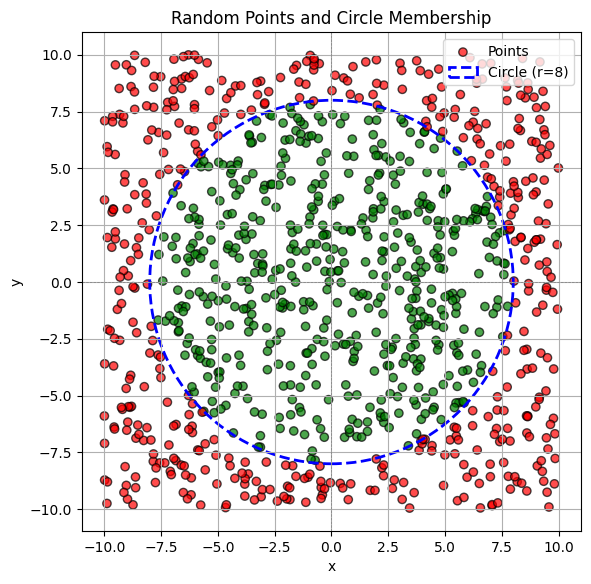

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
training_data = pd.read_excel('training_data.xlsx')

# Map inside_circle to colors
colors = training_data['inside_circle'].map({True: 'green', False: 'red'})

# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(training_data['x'], training_data['y'], c=colors, label='Points', alpha=0.7, edgecolor='k')

# Draw the circle of radius 8 centered at (0, 0)
circle = plt.Circle((0, 0), 8, color='blue', fill=False, linewidth=2, linestyle='--', label='Circle (r=8)')
plt.gca().add_patch(circle)

# Aesthetic settings
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.gca().set_aspect('equal')
plt.title('Random Points and Circle Membership')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


### Extracting Data

In [125]:
# Load training data
training_data = pd.read_excel("training_data.xlsx")
x_vals = training_data["x"].to_numpy()
y_vals = training_data["y"].to_numpy()
labels = training_data["inside_circle"].astype(int).to_numpy()

# Normalize coordinates
rmax = np.sqrt(np.max(x_vals**2 + y_vals**2))
x_norm = x_vals / rmax * np.pi
y_norm = y_vals / rmax * np.pi

### Defining P1 Projector

In [126]:
P1 = basis(2, 1) * basis(2, 1).dag()
Proj_q1 = tensor(qeye(2), P1)

### PQC

In [127]:
def circuit(x_angle, y_angle, params):
    state = tensor(basis(2, 0), basis(2, 0))  # |00⟩

    # Data encoding
    U0 = tensor(rx(x_angle), ry(y_angle))

    # Variational layer
    U1 = tensor(rx(params[0]), rx(params[1]))
    U2 = cnot(2, 0, 1)
    U3 = tensor(rx(params[2]), rx(params[3]))
    U = U3 * U2 * U1 * U0

    final = U * state
    
    return expect(Proj_q1, final).real

model_type = "(rx0 * rx0) (rx * rx)(cnot)(rx *rx)"

### Optmization

In [128]:
def loss(params):
    errs = []
    for x, y, label in zip(x_norm, y_norm, labels):
        e = circuit(x, y, params)
        errs.append((e - label)**2)
    return np.mean(errs)

init = np.random.uniform(0, 2*np.pi, 4)
result = minimize(loss, init, bounds=[[0, 2*np.pi], [0, 2*np.pi], [0, 2*np.pi], [0, 2*np.pi]])
opt_params = result.x

# Report
print("Learned params:", np.round(opt_params, 3))


Learned params: [0.014 5.614 4.005 3.811]


In [129]:
correct_percent = 0
for x, y, label in zip(x_norm, y_norm, labels):
    e = circuit(x, y, opt_params)
    pred = int(round(e))
    if pred == label:
        correct_percent += 1

efficency = correct_percent * 100 / len(labels)

print(f"{efficency} %")



83.0 %


In [130]:
import os
import pandas as pd

# Your new data
data = [{
    "model": model_type,
    "parms": opt_params,
    "efficency": efficency
}]

# File path
excel_path = "model_results.xlsx"

# Check if file exists, read old data if it does
if os.path.exists(excel_path):
    old_df = pd.read_excel(excel_path)
    new_df = pd.DataFrame(data)
    combined_df = pd.concat([old_df, new_df], ignore_index=True)
else:
    combined_df = pd.DataFrame(data)

# Save back to Excel
combined_df.to_excel(excel_path, index=False)